In [31]:
import pandas as pd
import os


In [32]:
df = pd.read_csv('energy.csv')

**Exploration du dataset**

In [33]:
print("Colonnes :", list(df.columns))
print("Types :")
print(df.dtypes)
print("Aperçu :")
display(df.head(5))

Colonnes : ['Temperature', 'Vaccum', 'Pressure', 'Humidity', 'Energy']
Types :
Temperature    float64
Vaccum         float64
Pressure       float64
Humidity       float64
Energy         float64
dtype: object
Aperçu :


,Temperature,Vaccum,Pressure,Humidity,Energy
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


**Nettoyage**

In [34]:
print(f"\n Nettoyage de la table ")

# 1. Suppression des doublons
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f" {before - after} doublons supprimés.")

    # 2. Traitement des valeurs manquantes
nulls = df.isnull().sum()
null_cols = nulls[nulls > 0]
if not null_cols.empty:
  print("Colonnes avec valeurs manquantes :")
  print(null_cols)
  for col in null_cols.index:
    if pd.api.types.is_numeric_dtype(df[col]):
      df[col] = df[col].fillna(0)
    else:
      df[col] = df[col].fillna("unknown")
else:
  print("Aucune valeur manquante détectée.")

    # 3. Affichage des types
print(" Types de colonnes :")
print(df.dtypes)


 Nettoyage de la table 
 41 doublons supprimés.
Aucune valeur manquante détectée.
 Types de colonnes :
Temperature    float64
Vaccum         float64
Pressure       float64
Humidity       float64
Energy         float64
dtype: object


In [35]:
print("\n🔎 Détection et traitement des outliers (méthode IQR)")

# Colonnes numériques à analyser
num_cols = ['Temperature', 'Vaccum', 'Pressure', 'Humidity', 'Energy']

# Boucle sur chaque colonne numérique
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Comptage des outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers détectés.")
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    print(f"\n--- {col} ---")
    print(f"{len(outliers)} outliers détectés.")

    # Affiche les 5 premières lignes anormales
    if not outliers.empty:
        print(outliers.head())
    else:
        print("Aucun outlier trouvé.")


🔎 Détection et traitement des outliers (méthode IQR)
Temperature: 0 outliers détectés.

--- Temperature ---
0 outliers détectés.
Aucun outlier trouvé.
Vaccum: 0 outliers détectés.

--- Vaccum ---
0 outliers détectés.
Aucun outlier trouvé.
Pressure: 91 outliers détectés.

--- Pressure ---
91 outliers détectés.
     Temperature  Vaccum  Pressure  Humidity  Energy
238        13.49   44.47   1030.46     69.49  466.66
319         9.25   41.82   1033.25     74.73  478.48
368        13.49   44.47   1030.18     69.15  468.46
536         9.11   40.02   1031.10     83.02  479.03
571         5.97   36.25   1029.65     86.74  487.03
Humidity: 13 outliers détectés.

--- Humidity ---
13 outliers détectés.
      Temperature  Vaccum  Pressure  Humidity  Energy
789         34.30   74.67   1015.98     25.89  427.84
2262        33.94   74.67   1015.94     28.16  427.98
3603        19.78   44.71   1015.70     29.43  465.49
4367        34.65   74.67   1016.03     26.67  427.69
5349        37.11   68.94   

**Préparation à la modélisation**

In [36]:
X = df[['Temperature', 'Vaccum', 'Pressure', 'Humidity']]
y = df['Energy']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Dimensions X_train :", X_train_scaled.shape)
print("Dimensions X_test :", X_test_scaled.shape)
print("y_train :", y_train.shape)
print("y_test :", y_test.shape)




Dimensions X_train : (7621, 4)
Dimensions X_test : (1906, 4)
y_train : (7621,)
y_test : (1906,)


**Neural Network Building**

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score


In [39]:
# Création du modèle séquentiel
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])


In [40]:
model.compile(
    optimizer='adam',
    loss='mse',        # Mean Squared Error (adapté à la régression)
    metrics=['mae']    # Mean Absolute Error
)


In [41]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,  # 20% du train pour validation
    epochs=30,
    batch_size=16,
    verbose=1
)


Epoch 1/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 179351.3125 - mae: 417.2914 - val_loss: 20254.0898 - val_mae: 121.5654
Epoch 2/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15372.6074 - mae: 104.9942 - val_loss: 4599.1372 - val_mae: 56.7609
Epoch 3/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3239.4165 - mae: 46.6186 - val_loss: 1012.5016 - val_mae: 24.3848
Epoch 4/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 747.5015 - mae: 21.1394 - val_loss: 387.9365 - val_mae: 14.7279
Epoch 5/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 306.7073 - mae: 13.0202 - val_loss: 194.8737 - val_mae: 9.9578
Epoch 6/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 153.3410 - mae: 9.0961 - val_loss: 112.9041 - val_mae: 7.4996
Epoch 7/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 92.8265 - mae: 7.0617 - val_loss: 74.0502 - val_mae: 6.1102
Epoch 8/30
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 60.2074 - mae: 5.6901 - val_loss: 53.0136 - val_mae: 5.3212
Epoch 

In [42]:
y_pred = model.predict(X_test_scaled).flatten()

# Évaluation
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score


# Calcul des métriques
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Affichage
print("Évaluation du modèle :")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Explained Variance Score: {evs:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Si tu veux vérifier la loss sur X_test
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss (MSE) : {test_loss:.2f}")
print(f"Test MAE : {test_mae:.2f}")




60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Évaluation du modèle :
Mean Absolute Error (MAE): 3.41
Mean Squared Error (MSE): 18.85
Root Mean Squared Error (RMSE): 4.34
R² Score: 0.94
Explained Variance Score: 0.94
Mean Absolute Percentage Error (MAPE): 0.75%
Test Loss (MSE) : 18.85
Test MAE : 3.41


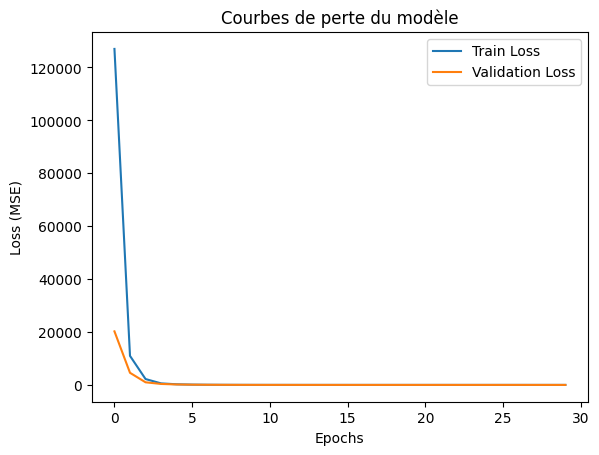

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Courbes de perte du modèle')
plt.show()


In [44]:
model.save("energy_nn_model.h5")
print("Modèle sauvegardé")


Modèle sauvegardé
